### **군집화 기반 앙상블 페어선택 알고리즘**
기여자 : 12기 최문석, 13기 최원준  

페어트레이딩을 위한 페어선택 알고리즘을 테스트합니다.

## 1. 동기

## 2. 관련 연구

## 3. 데이터셋
- 데이터셋은 FnGuide에서 제공하는 데이터를 사용하였습니다.


In [79]:
import os
import glob
import math
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

In [80]:
# matplotlib library load
import matplotlib.pyplot as plt

# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [81]:
# Try loading the CSV data with 'CP949' encoding (common for Korean text)
csv_data = pd.read_csv(r"C:\Users\user\Desktop\B to E PT\20년dataset4.csv", encoding='CP949')

# Display the first few rows of the data to understand its structure
csv_data.head()

C:\Users\user\AppData\Local\Temp\ipykernel_31620\3309215020.py:2: DtypeWarning: Columns (3,4,9,12,18,20,26,27,28,30,32,36,37,44,48,50,54,56,61,63,65,66,68,71,72,73,75,77,80,82,89,91,92,94,96,108,109,112,113,115,116,119,124,130,131,132,133,136,142,143,146,152,153,154,155,158,161,162,163,166,168,169,173,174,175,180,183,185,186,187,192,194,198,199,202,203,204,207,209,210,212,215,216,217,218,220,222,230,231,232,236,245,248,250,251,252,258,259,260,261,262,263,267,269,271,276,279,282,285,286,287,288,290,293,294,295,297,299,300,302,303,312,314,317,318,319,322,323,325,327,328,340,351,353,357,365,374,378,379,391,393,395,397,399,400,402,405,406,408,410,413,415,416,419,422,423,427,438,439,445,446,448,450,451,454,464,465,467,468,473,475,477,486,493,495,496,498,499,504,506,508,510,511,517,519,521,526,543,546,558,560,561,562,565,571,572,574,576,579,580,586,591,596,599,600,601,605,616,621,622,623,625,627,635,639,641,643,648,652,659,663,667,671,676,678,679,680,684,687,689,690,695,698,700,702,703,704,7

,Symbol,A005930,A000660,A373220,A207940,A005380,A000270,A068270,A005490,A105560,...,A152330,A192520,A192530,A380440,A443060,A900030,A900050,A950010,A950070,A950100
0,Symbol Name,삼성전자,SK하이닉스,LG에너지솔루션,삼성바이오로직스,현대차,기아,셀트리온,POSCO홀딩스,KB금융,...,코리아오토글라스,경남은행,광주은행,엔에이치스팩19호,에이치디현대마린솔루션,연합과기,중국원양자원,평산차업 KDR,중국고섬,SBI모기지
1,2004-04-01,"11,500","12,450",NaN,NaN,"52,000","11,850",NaN,"160,500",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004-04-02,"11,300","12,550",NaN,NaN,"51,900","11,700",NaN,"165,000",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004-04-06,"11,900","13,750",NaN,NaN,"53,300","11,950",NaN,"165,000",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004-04-07,"12,000","13,750",NaN,NaN,"54,900","12,300",NaN,"168,500",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
csv_data.columns = csv_data.iloc[0]  # Set the first row as column names
csv_data = csv_data.iloc[1:]  # Remove the first row
csv_data.set_index('Symbol Name', inplace=True)

# Convert all price data from string to float after removing commas
csv_data = csv_data.replace(',', '', regex=True).astype(float)

In [83]:
csv_data = csv_data.loc['2004-04-01':'2019-03-31']

In [102]:
data = csv_data.dropna(axis=1)
data = np.log(data / data.shift(1))
data = data.dropna(axis=0)
log_return_data = data
scaler = StandardScaler()
datanp = scaler.fit_transform(data.T)
data = pd.DataFrame(datanp, columns=data.index, index=data.columns)

In [85]:
data

Symbol Name,2004-04-02,2004-04-06,2004-04-07,2004-04-08,2004-04-09,2004-04-12,2004-04-13,2004-04-14,2004-04-16,2004-04-19,...,2019-03-18,2019-03-19,2019-03-20,2019-03-21,2019-03-22,2019-03-25,2019-03-26,2019-03-27,2019-03-28,2019-03-29
0,,,,,,,,,,,,,,,,,,,,,
삼성전자,-0.836113,1.597018,0.064190,0.095941,-0.389738,0.494287,0.385900,-0.048489,-1.032388,0.192185,...,-0.742268,0.251614,0.408618,2.489007,0.766264,-0.215627,-0.471781,0.145892,0.007766,-0.510864
SK하이닉스,0.176839,3.057664,-0.203141,-0.796640,0.453398,-0.303090,0.767063,-1.633765,-1.908027,0.441754,...,-0.460141,0.192321,1.989888,4.153154,0.189491,-0.891654,-0.351459,0.466510,-0.179111,0.648673
현대차,-0.216732,0.670125,0.741723,0.182053,-0.636399,-0.362234,-0.515293,-0.057408,0.192294,-0.838458,...,0.711300,0.084562,0.243640,0.712867,-0.303251,-0.414786,-0.779693,0.049924,0.915322,-0.340446
기아,-0.645561,0.468086,0.719072,-0.046146,-1.254400,-0.574501,-0.605552,0.744068,-0.063105,0.751678,...,0.843748,0.084562,0.452264,-0.413765,0.470598,-0.137901,0.153102,0.682736,0.321704,0.642929
POSCO홀딩스,0.956112,-0.312098,0.467412,1.181339,0.493038,-0.667029,-0.842573,0.606565,-0.860169,-0.183207,...,-0.904705,0.296645,-0.318759,0.801945,0.246472,-0.236564,0.025686,0.135249,0.432621,-0.565852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
우리종금,-0.261114,-0.312098,-0.496674,-0.285251,0.302687,-0.204699,0.843878,2.192869,1.385028,3.538189,...,-0.281219,0.227936,-0.391091,0.514469,-0.237024,0.191077,-0.173290,-0.301616,0.080835,-0.654283
두산건설,-0.925617,0.055059,-0.441234,-0.098610,0.194639,0.013985,0.463561,-0.327902,0.460797,-0.732496,...,-0.853499,-0.411690,0.572785,-0.196541,0.419118,-0.196634,-0.536986,0.723944,0.164437,0.391457
부산가스,-0.305973,-0.622195,-0.068632,-0.323063,0.342267,-0.437938,-0.058161,0.152060,0.206416,-0.084737,...,0.293625,-0.173985,0.471781,0.745934,0.068261,0.114935,-0.180157,-1.045446,-1.322680,-0.196101


In [86]:
from scipy.linalg import svd
U, s, VT = svd(data)

In [87]:
V = VT.T
PC_V = V[:,0:15]
print(PC_V.shape)

(3710, 15)


In [88]:
eigendata = data@PC_V
eigendata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
삼성전자,-2.054460,7.289065,-1.756869,8.777829,-0.722100,0.052250,-0.197368,1.590583,-1.045808,1.886990,-2.412364,3.203469,-4.188270,2.585060,-0.980329
SK하이닉스,-8.320846,0.848111,-5.481602,9.307760,-1.143995,1.238124,0.392523,2.210808,0.521045,3.042840,-3.012111,2.807655,-5.329927,5.653522,-2.857290
현대차,-4.408095,10.914491,0.240766,8.071209,-0.736486,-3.331561,0.097596,1.462749,7.007379,1.709098,-3.398445,-0.390268,-5.106058,3.863354,-7.333039
기아,-4.502047,10.368386,-1.195274,7.325360,-0.651379,-2.325766,-0.863277,1.215089,7.055238,1.874416,-3.668032,0.167282,-6.403460,3.602849,-7.171412
POSCO홀딩스,-8.552278,10.690904,3.027907,2.135923,-0.080422,-3.305058,-1.870768,-1.049222,2.275214,-1.463925,0.755308,-2.349537,0.292251,-3.684687,2.504635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
우리종금,-4.372709,-1.762319,2.151706,2.784794,1.467386,6.541807,2.495530,-4.668014,-8.393475,-4.495369,-0.775704,-1.397271,0.970472,3.933931,3.222835
두산건설,-16.214435,-1.373653,4.336051,-7.273922,2.192726,4.336120,-2.722555,-4.449174,-6.838988,-5.444697,1.390707,-4.414360,0.288588,0.842357,1.991525
부산가스,10.181581,7.863968,3.687217,2.253450,-0.291920,0.033575,-0.050664,-0.638939,-1.763381,-1.708033,0.271809,-0.222656,0.230391,-1.026078,-0.078014


In [89]:
pc_names = ['PC' + str(i) for i in range(1, len(eigendata.columns) + 1)]
eigendata.columns = pc_names

In [90]:
pca_df = eigendata

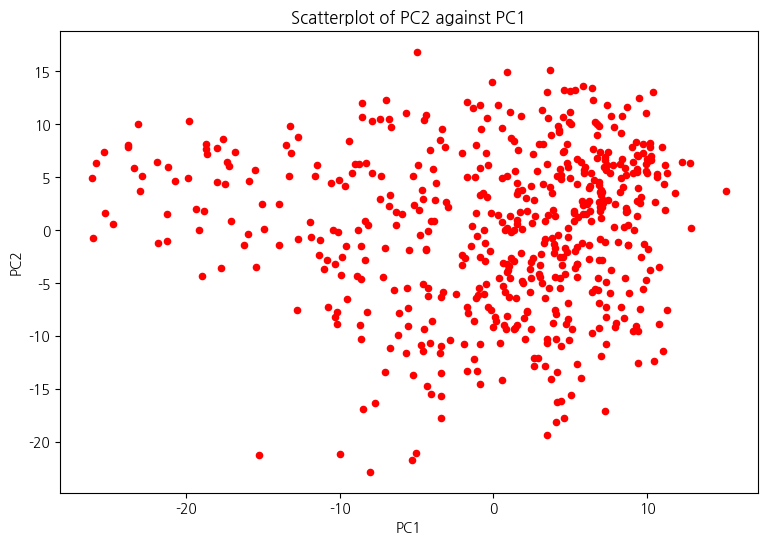

In [91]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots(figsize=(9,6))
pca_df.plot(x="PC1", y="PC2", kind="scatter", marker="o",
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
plt.show()

---

**20개 주성분 선택**  
카이저-가트맨 규칙(Kaiser-Guttman Criterion)의 고윳값1기준

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\

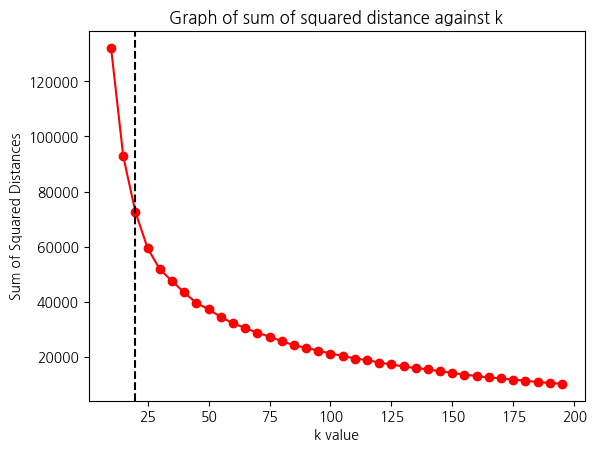

From the graph above, we can see that the optimal k-value is at the elbow, at k = 20


In [92]:
'''Make a pointer to store clustering results'''

cluster_results = {}

'''K-Means Clustering'''

def optimise_k(pca_df):

    error = []
    ks = []
    
    for i in range(10, 200, 5): # For loop from 10 to 200 with intervals of 5 and calculate the respective sum of squared distances for i number of centroids

        # Initialise the KMeans function with the i number of centroids.
        # By default, KMeans function uses the KMeans++ Method of initialisation the centroids.
        kmeans = KMeans(n_clusters=i) 
        
        # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
        kmeans.fit(pca_df)
        
        # Using the attribute ".inertia_" returns the sum of squared distances of datapoints to their closest cluster center.
        # It is appended into error to be plotted as the y-axis.
        error.append(kmeans.inertia_)
        
        # The number of centroids, i, is appended to ks to be plotted as the x-axis.
        ks.append(i)
    
    # Plot graph of "Sum of Squared Distances" against "k value".
    # Using this graph, the optimal number of centroids can be found via the elbow method
    plt.plot(ks, error, marker="o", color="r")
    plt.title("Graph of sum of squared distance against k")
    plt.xlabel("k value")
    plt.ylabel("Sum of Squared Distances")
    plt.axvline(20, color='black', linestyle='--')
    plt.show()

def cluster_kmeans(pca_df, k):

    # Initialise the KMeans function with the k number of centroids.
    kmeans = KMeans(n_clusters=k)

    # Fits the model with pcd_df and applies KMeans algorithm on pca_df.
    kmeans.fit(pca_df)

    # Using the method .predict(X), it calculates the closest cluster each datapoint in dataset X belongs to.
    results = kmeans.predict(pca_df)

    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, k={k}", c=results, cmap="jet", ax=ax)
    plt.show()
    return results

optimise_k(pca_df)
print(f"From the graph above, we can see that the optimal k-value is at the elbow, at k = 20")

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


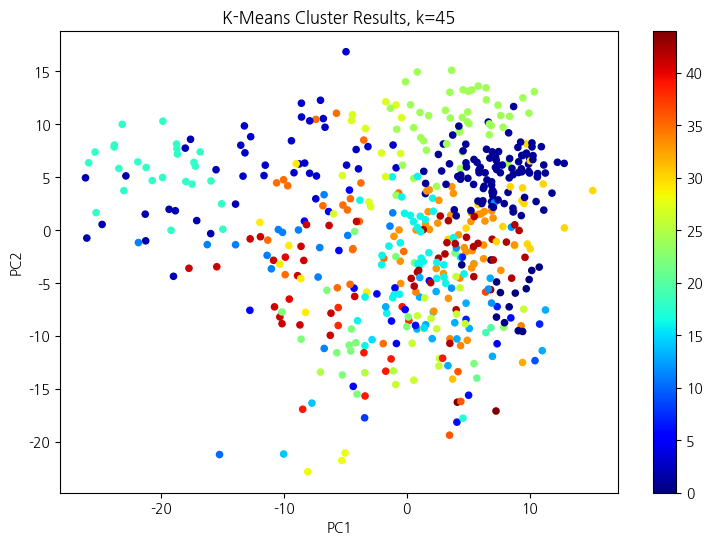

Therefore, we plot the K-Means results for the optimal k-value, 45


In [93]:
'''Plotting the K-Means Cluster Results'''

# K-Means Clustering is applied on pca_df for k = 45
kmeans_results = cluster_kmeans(pca_df,k=45)

# K-Means Clustering results are saved in cluster_results
cluster_results[f"KMeans"] = kmeans_results

print(f"Therefore, we plot the K-Means results for the optimal k-value, 45")

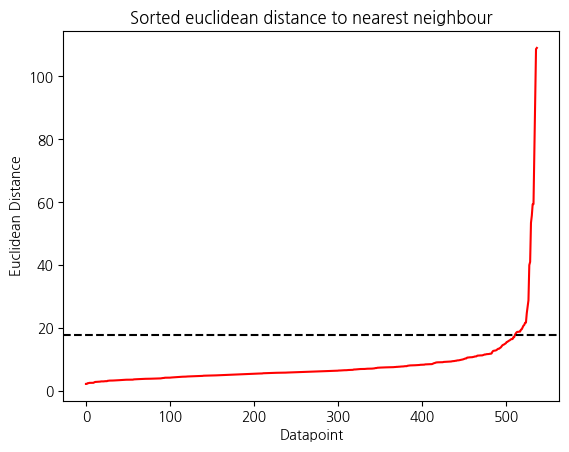

From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18


In [94]:
'''
DBSCAN Clustering:
'''

def optimise_epsilon(pca_df):

    # Initialise the NearestNeighbors function with 2 neighbors 
    # This is to find optimal value of epsilon based on an optimisation algorithm
    neigh = NearestNeighbors(n_neighbors=2)

    # Fits the model with pcd_df
    nbrs = neigh.fit(pca_df)

    # Using the method .kneighbors(X), the k-Neighbours for datatpoints in datatset X are found
    # By default, this method returns the distances array which is found in the 0 index
    distances = nbrs.kneighbors(pca_df)[0]

    # Sort distances row-wise
    distances = np.sort(distances,axis=0) 

    # Remove the 0-index value (Euclidean distance to itself which is 0)
    distances = distances[:,1:]

    # Plot graph of "Euclidean Distance" against "Datapoint".
    # Using this graph, the optimal epsilon value can be found via the elbow method
    plt.plot(distances, color="r")
    plt.title("Sorted euclidean distance to nearest neighbour")
    plt.xlabel("Datapoint")
    plt.ylabel("Euclidean Distance")
    plt.axhline(y=18, color='black', linestyle='--')
    plt.show()    

def cluster_dbscan(pca_df, eps, min_samples):

    # Initialise the DBSCAN function with eps and min_samples.
    # eps is a float value and is the maximum distance between two samples for one to be considered as in the neighborhood of the other
    # min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. 
    # This includes the point itself.
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Using the method .fit_predict(X), clusters from a data or distance matrix and predict labels are computed
    results = dbscan.fit_predict(pca_df)
    
    # Plot the cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="jet", ax=ax)
    plt.show()

    # Get number of clusters formed.
    num_clusters = np.max(results)
    print(f"For the epsilon value of {eps}, the number of clusters is {num_clusters}")

    return results

optimise_epsilon(pca_df) 
print(f"From the graph above, we can see that the optimal epsilon is at the elbow, at epsilon = 18")

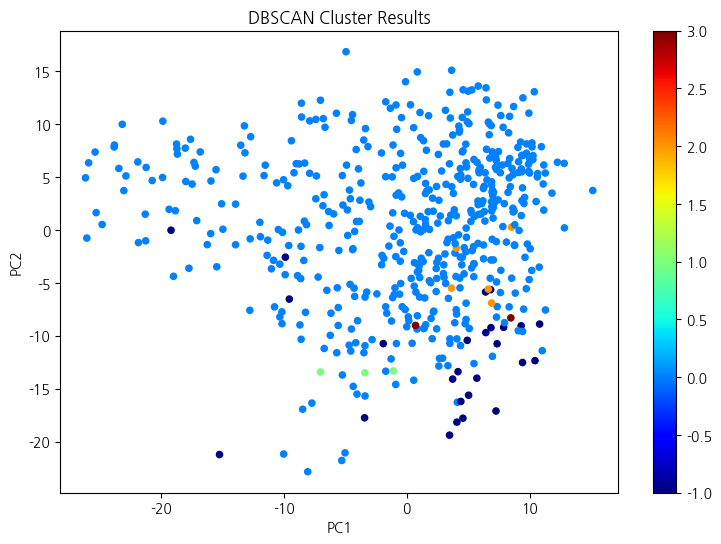

For the epsilon value of 18, the number of clusters is 3


In [95]:
'''Plotting the DBSCAN Cluster Results'''

# DBSCAN Clustering is applied on pca_df for eps = 20 and min_samples = 2
results = cluster_dbscan(pca_df, eps=18, min_samples=2)

# DBSCANS Clustering results are saved in cluster_results, a dict
cluster_results["DBSCAN"] = results

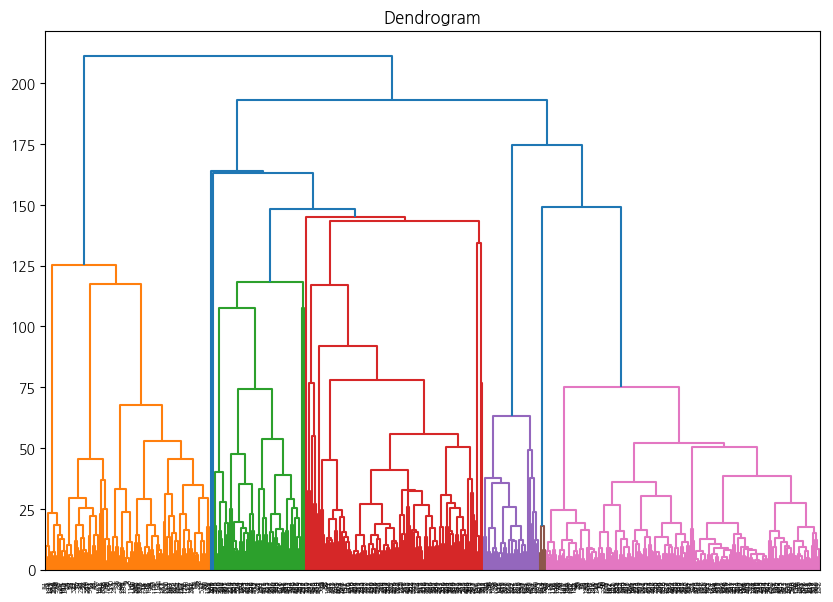

In [96]:
'''
Hierarchical Clustering (AgglomerativeClustering)
'''

def cluster_hierar(pca_df, n):

    # Initialise the AgglomerativeClustering function with n clusters.
    # Fits the model with pca_df and applies Agglomerative Clustering algorithm on pca_df.
    hierar = AgglomerativeClustering(n_clusters=n, ).fit(pca_df)

    # Using the method .fit_predict(X), it fits and return the result of each datapoint's clustering assignment.
    results = hierar.fit_predict(pca_df)

    # Plot cluster results.
    fig, ax = plt.subplots(figsize=(9,6))
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"Agglomerative Clustering Results, n={n}", c=results, cmap="jet", ax=ax)
    plt.show()

    return results

def draw_dendrogram(pca_df):
    
    # Initialise Linkage function with linkage method = "ward".
    # linkage returns a linkage matrix, which is needed for the dendrogram to be plotted.
    linked = linkage(pca_df,method = "ward") 

    # Plot dendrogram results.
    plt.figure(figsize =(10,7))
    plt.title("Dendrogram")
    dendrogram(linked,
                orientation = "top",
                distance_sort = "descreasing",
                show_leaf_counts = True)
    plt.show()

draw_dendrogram(pca_df)

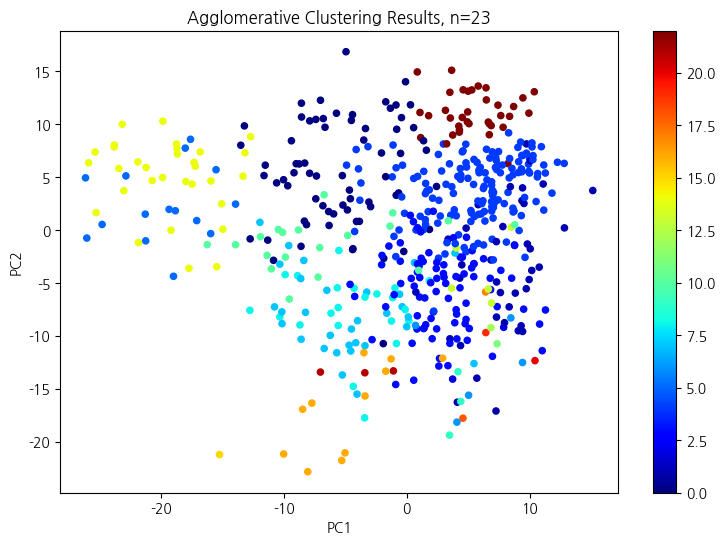

In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints


In [97]:
'''Plotting the Hierarchical Cluster Results'''
# Hierarchical Clustering is applied on pca_df for n_clusters = sqrt(N)
results = cluster_hierar(pca_df, int(pca_df.shape[0]**0.5)) 

# Hierarchical Clustering results are saved in cluster_results
cluster_results["Hierarchical"] = results

print(f"In the case of Hierarchical Clustering, we chose the optimal number of clusters to be sqrt(N)=22, where N is the number of datapoints")

In [98]:
'''
Cluster Results -> Groupings of stocks/ETFs:
1. First, we need to map the cluster ids to the symbols of our stocks to get groups of stocks
2. Then store the clusters into a pointer -> "groups"
'''
norm_symbols = pca_df.index

# Return array of the symbols of stocks.
print(norm_symbols.shape) 

# Contains cluster group assignments for each algorithm.
print([x.shape for x in cluster_results.values()])

def map_clusters(cluster_result):
    grouping = [[] for _ in range(max(cluster_result)+1)]
    for i, res in enumerate(cluster_result):
        grouping[res].append(norm_symbols[i])
    
    grouping = [g for g in grouping if 1<len(g)<=10] # Keep clusters with <=10 members.
    
    return grouping

groups = {}
for algorithm, cluster_result in cluster_results.items():
    groups[algorithm] = map_clusters(cluster_result)


print("Number of valid clusters:", {k:len(v) for k,v in groups.items()})
print("Example cluster:", groups["Hierarchical"][0])

(538,)
[(538,), (538,), (538,)]
Number of valid clusters: {'KMeans': 14, 'DBSCAN': 2, 'Hierarchical': 5}
Example cluster: ['이엔플러스', '대우부품']


In [99]:
for i in range(0,len(groups["KMeans"])):
    print("Example cluster:", groups["KMeans"][i])

Example cluster: ['미래산업', '우성', '세우글로벌', '한창']
Example cluster: ['한국제지', '갤럭시아에스엠', '씨아이테크', '국동']
Example cluster: ['사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산']
Example cluster: ['동양철관', '대호에이엘']
Example cluster: ['대유에이텍', '대유플러스']
Example cluster: ['삼화콘덴서', '삼화전기', '삼화전자']
Example cluster: ['광명전기', '일신석재', '선도전기']
Example cluster: ['HMM', '쌍용C&E', '현대엘리베이', '남해화학', '한일현대시멘트', '현대코퍼레이션', '성신양회']
Example cluster: ['한올바이오파마', 'JW중외제약', '영진약품', '파미셀', '일양약품']
Example cluster: ['신일전자', '팜젠사이언스', '에이엔피']
Example cluster: ['엘앤에프', '코스모신소재', '코스모화학']
Example cluster: ['대원전선', '신원', '일성건설', '하이스틸', '조비', '부산산업', '인디에프']
Example cluster: ['삼부토건', '진흥기업']
Example cluster: ['에이프로젠바이오로직스', '오리엔트바이오']


In [100]:
for i in range(0,len(groups["Hierarchical"])):
    print("Example cluster:", groups["KMeans"][i])

Example cluster: ['미래산업', '우성', '세우글로벌', '한창']
Example cluster: ['한국제지', '갤럭시아에스엠', '씨아이테크', '국동']
Example cluster: ['사조대림', '사조산업', '신라교역', '사조오양', '한성기업', '동원수산']
Example cluster: ['동양철관', '대호에이엘']
Example cluster: ['대유에이텍', '대유플러스']


In [101]:
for i in range(0,len(groups["DBSCAN"])):
    print("Example cluster:", groups["KMeans"][i])

Example cluster: ['미래산업', '우성', '세우글로벌', '한창']
Example cluster: ['한국제지', '갤럭시아에스엠', '씨아이테크', '국동']


In [120]:
cumulative_log_returns = log_return_data.cumsum()
cumulative_returns = np.exp(cumulative_log_returns) - 1

In [124]:
def clusterCumsumPlot(name_clustering_algorithm):
    for i in range(0, len(groups[name_clustering_algorithm])):
        plt.figure(figsize=(10, 6))
        cluster = groups[name_clustering_algorithm][i]
        for stock in cluster:
            if stock in cumulative_returns.columns:
                cumulative_returns[stock].plot(label=stock)
        plt.title(f'{name_clustering_algorithm} 군집화 알고리즘 - {i+1}번째 군집')
        plt.xlabel('날짜')
        plt.ylabel('누적수익률')
        plt.legend()
        plt.grid(True)
        plt.show()

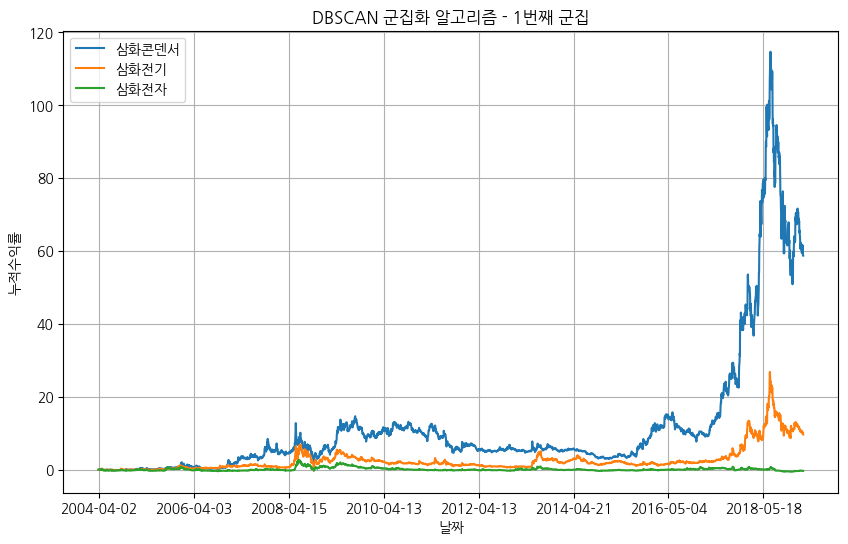

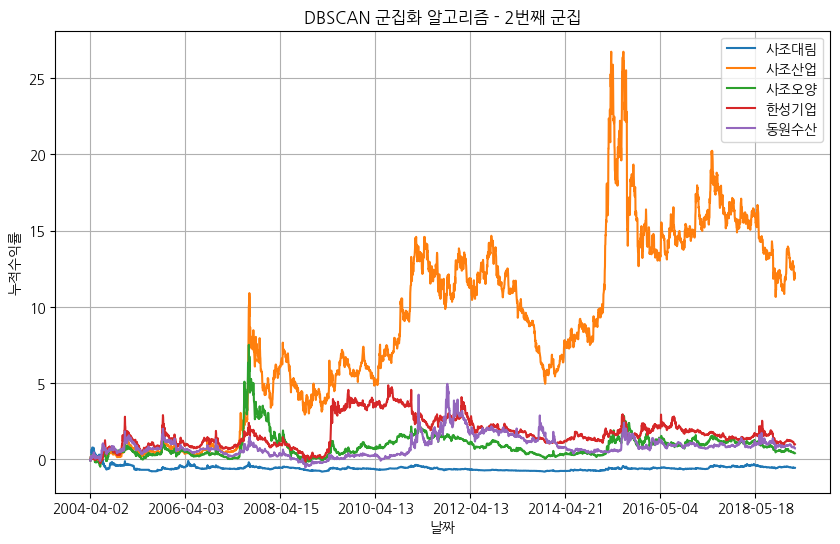

In [125]:
clusterCumsumPlot("DBSCAN")

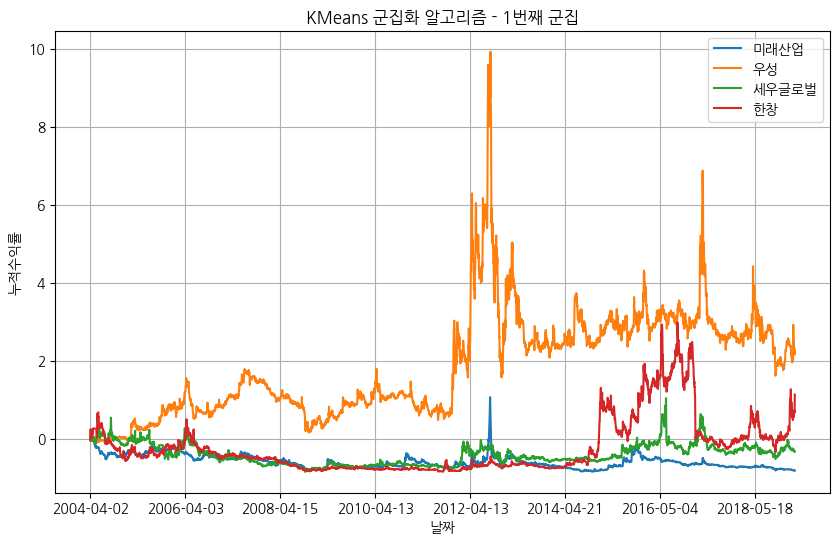

<Figure size 1000x600 with 0 Axes>

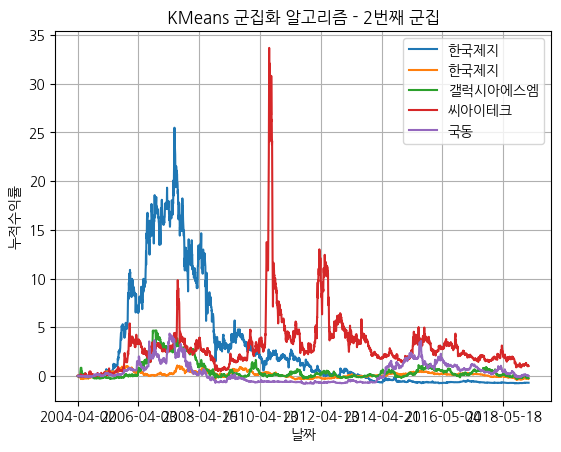

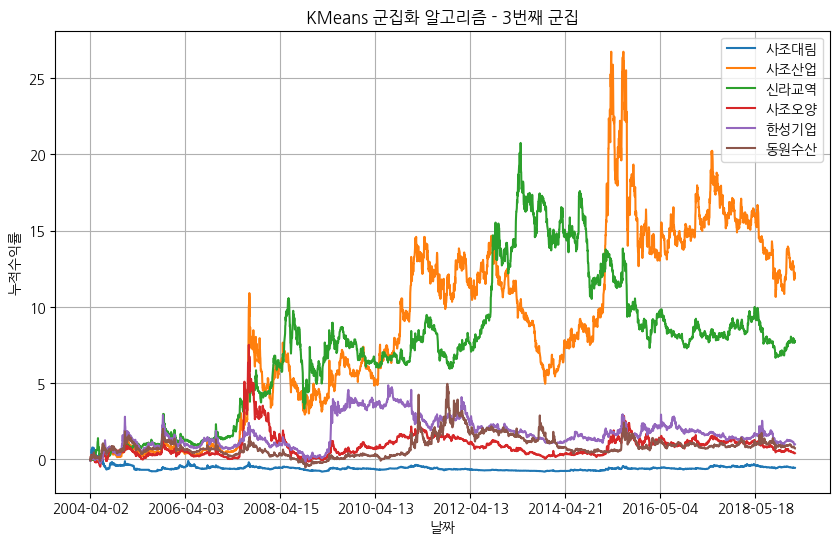

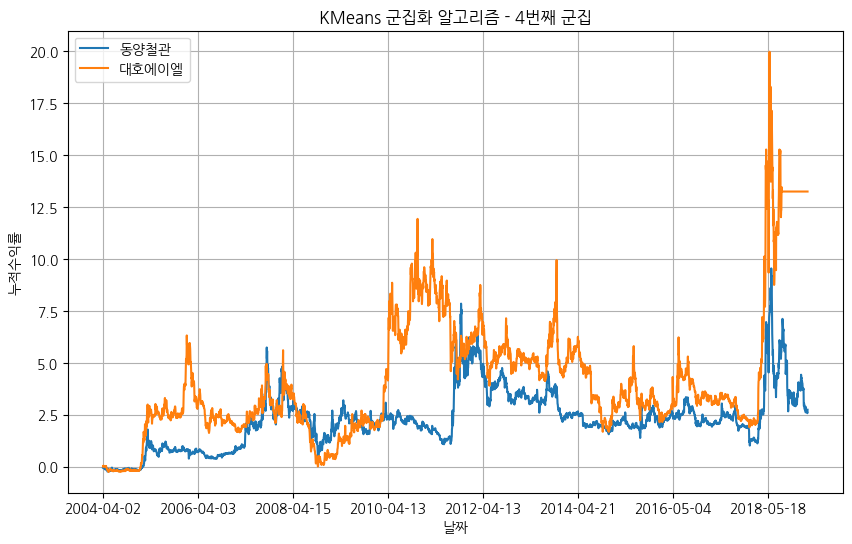

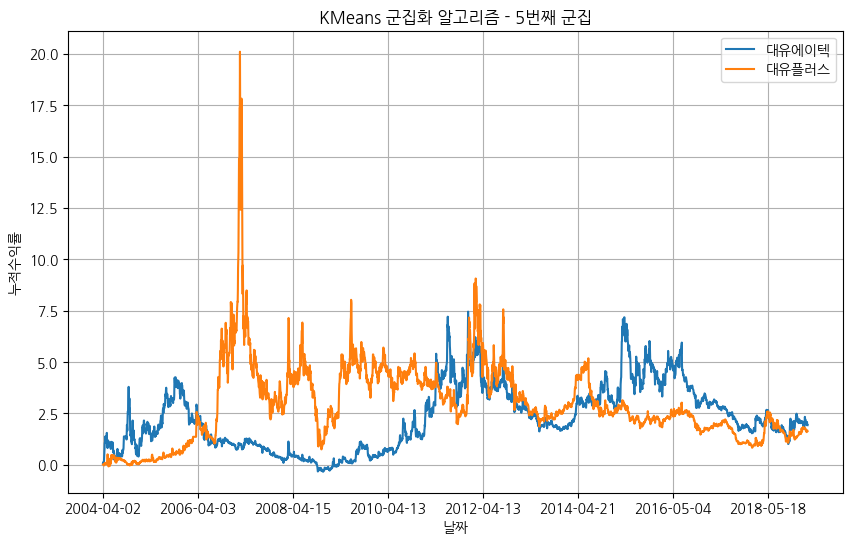

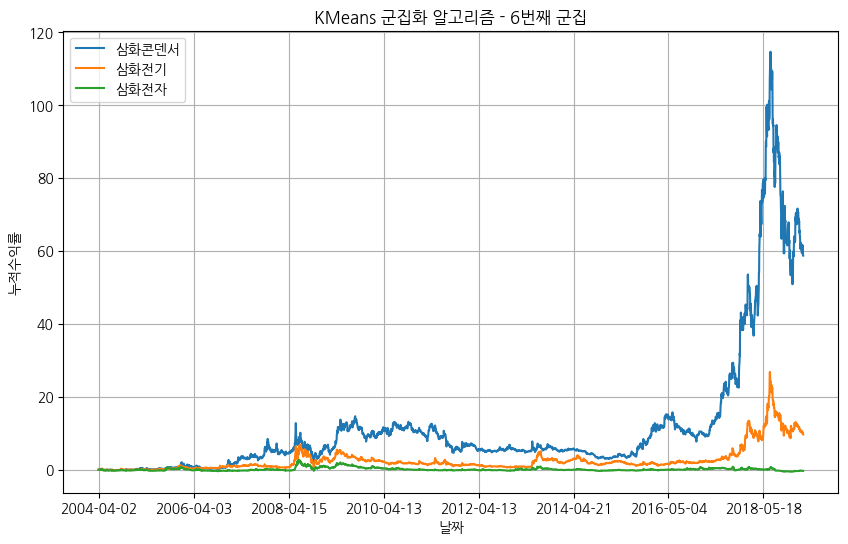

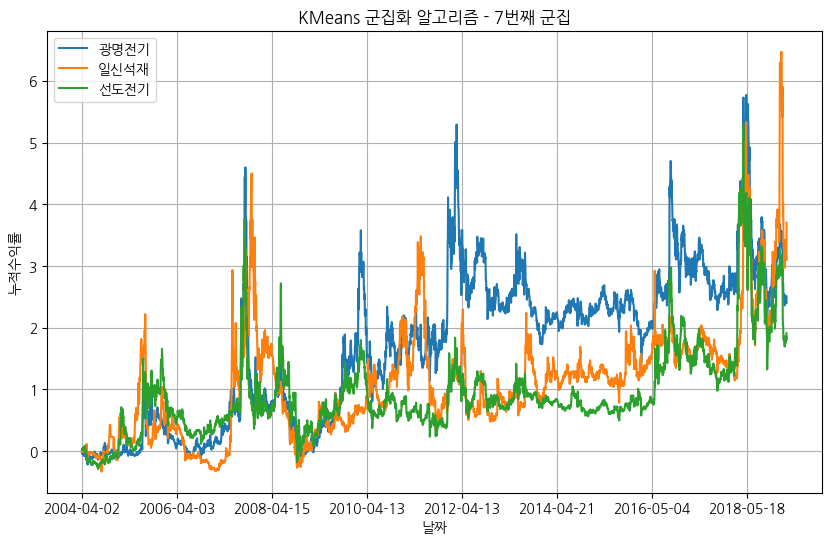

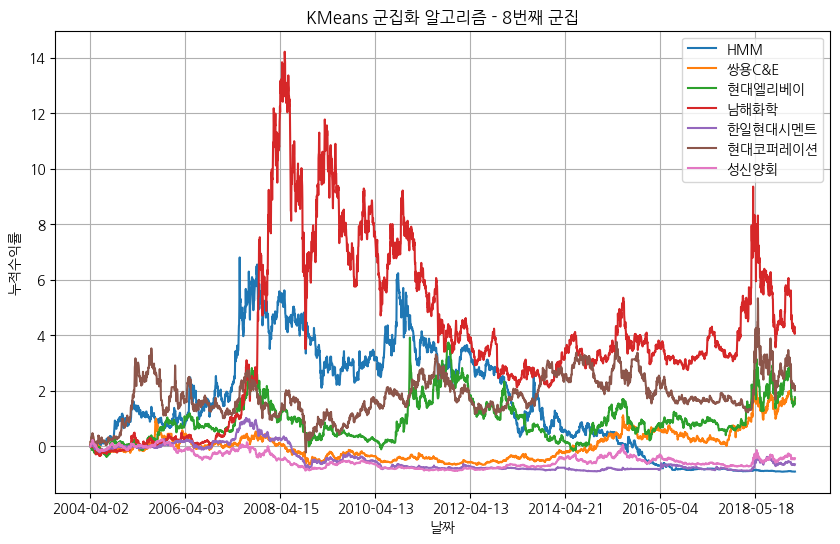

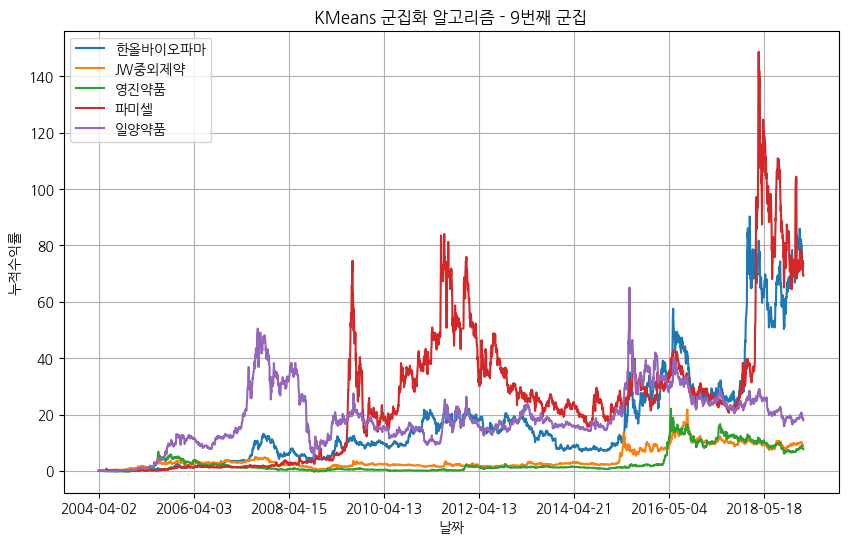

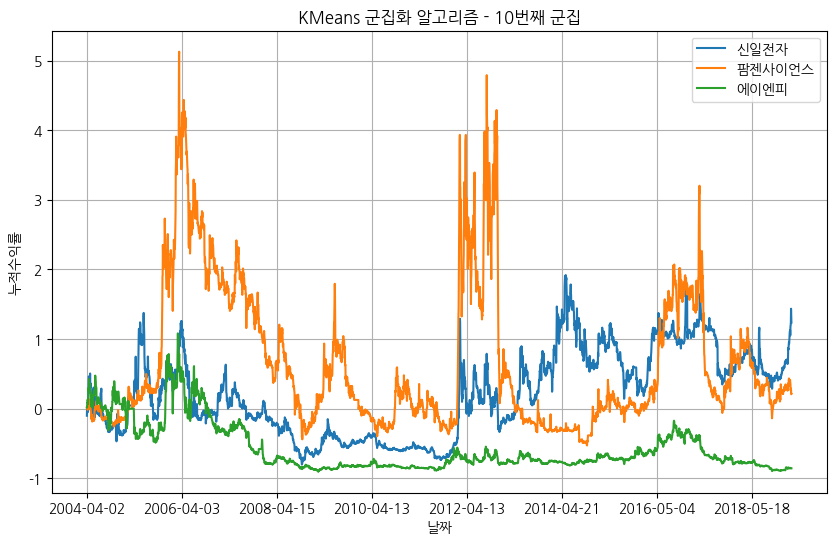

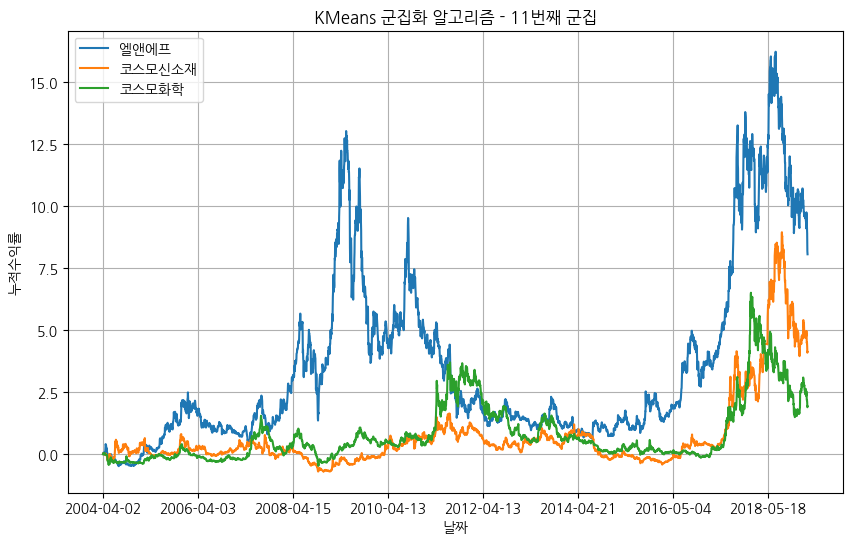

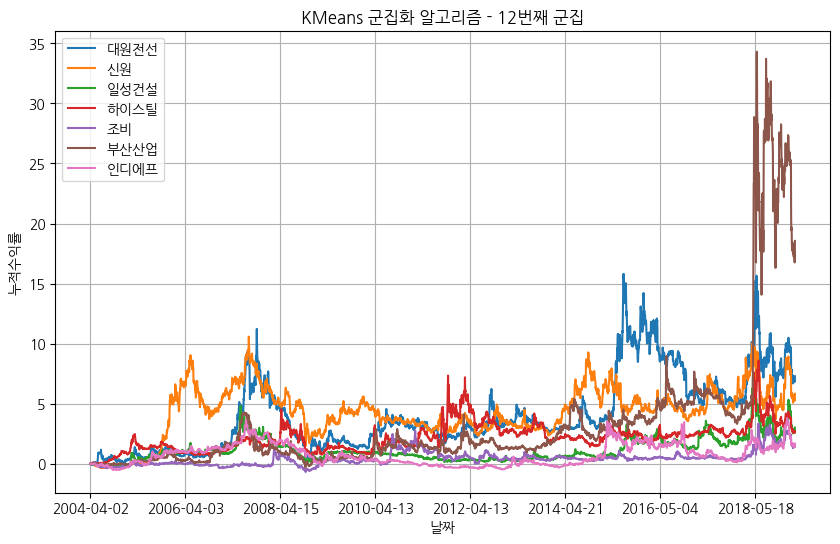

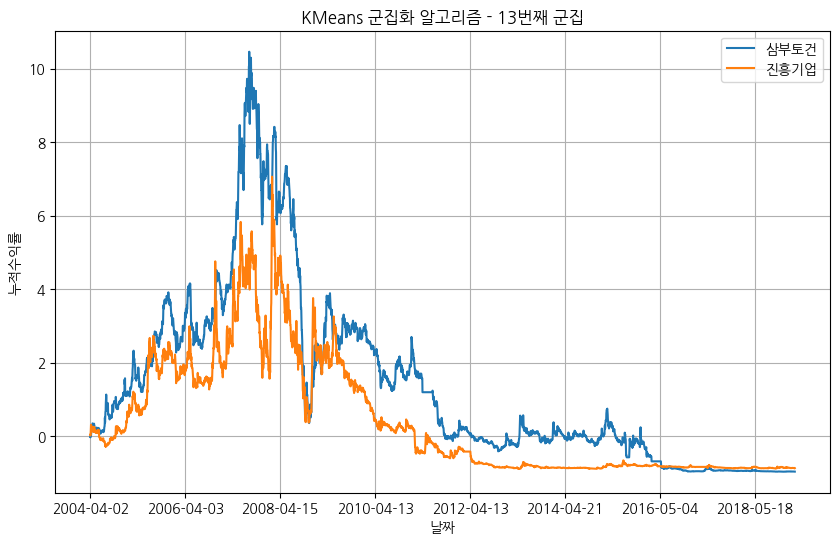

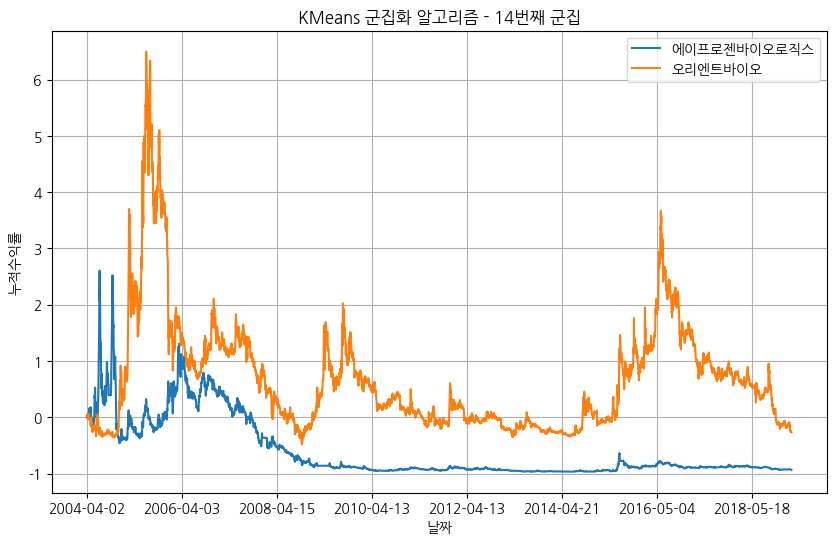

In [126]:
clusterCumsumPlot("KMeans")

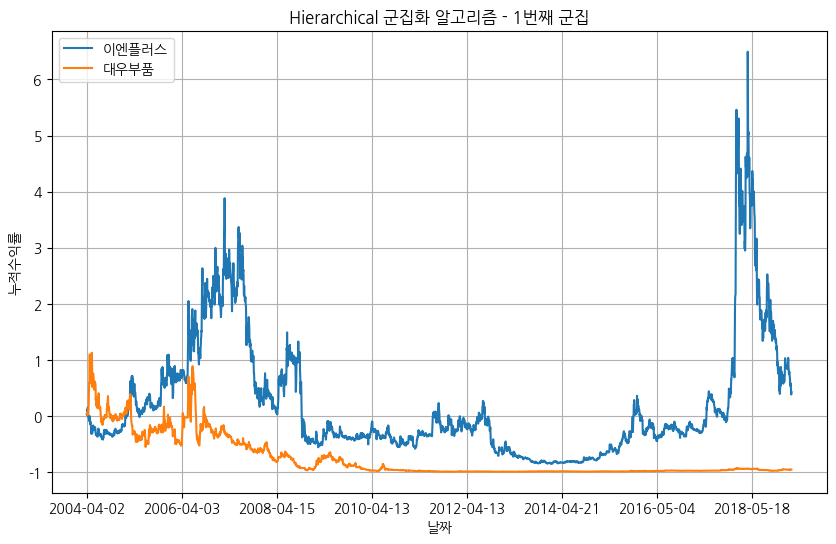

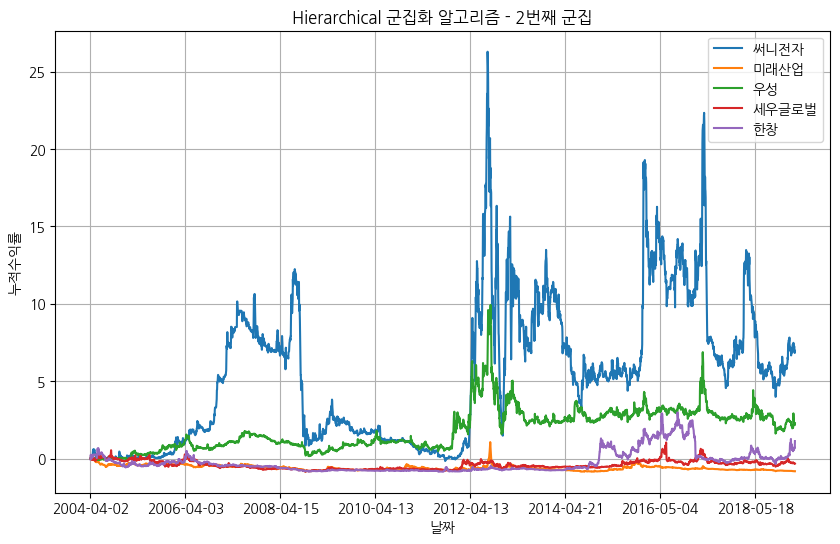

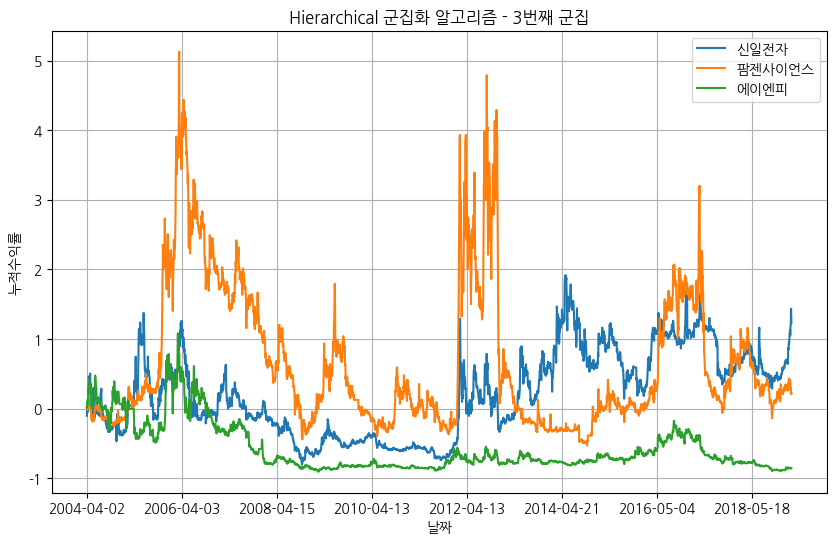

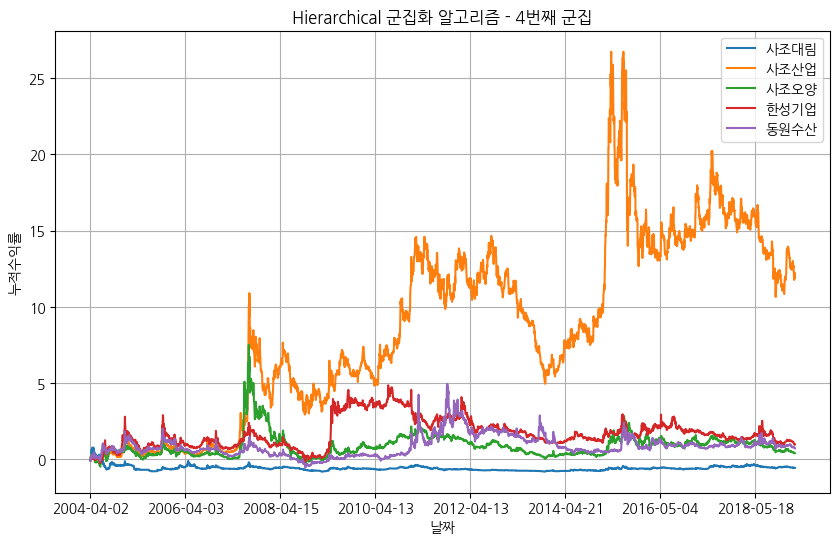

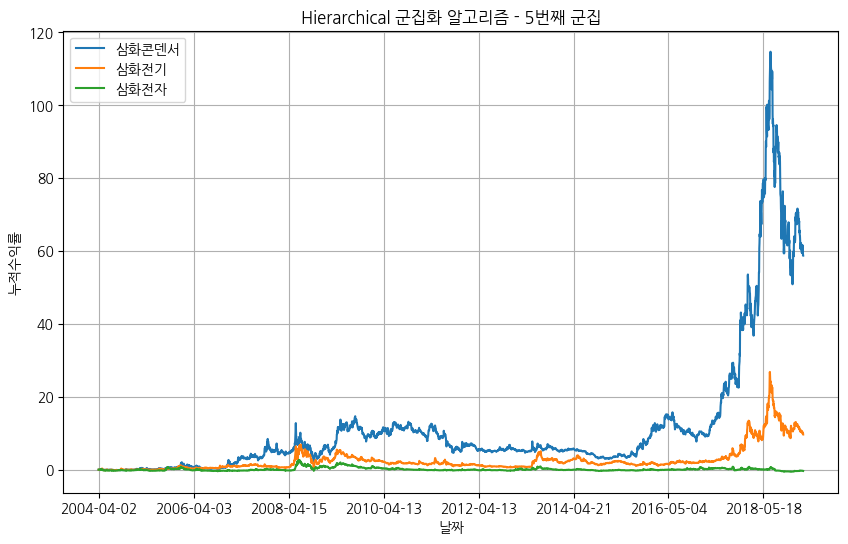

In [127]:
clusterCumsumPlot("Hierarchical")

## 4. Evaluation